In [2]:
"""  
此文件用于获取 developing disturbance data 和 non-developing disturbance data
文件00： 已经获取到每个时刻的中心点了， 本文件主要对不同时刻进行追踪
文件02：  扰动和不发展扰动还未分离
注意：    所拿到的场的数据要比想要的场数据大8圈 



"""


'  \n此文件用于获取 developing disturbance data 和 non-developing disturbance data\n文件00： 已经获取到每个时刻的中心点了， 本文件主要对不同时刻进行追踪\n注意：    所拿到的场的数据要比想要的场数据大8圈 \n      \n\n'

In [3]:
import xarray  as xr
import numpy as np
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import matplotlib.pyplot as plt   
from matplotlib import colormaps
from typing import Tuple ,  List , Set, Any
from numpy.typing import NDArray 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.patches import Rectangle
from scipy import ndimage
from collections import defaultdict


# 数据处理和绘图class 

In [4]:
"""  获取数据类  """
class getInitData( object):
    def __init__(self, init_data_pth):
        self.init_data_pth = init_data_pth

    # 获取原始数据
    def get_init_data(self)-> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.datetime64]:
        init_data =  xr.open_dataset(self.init_data_pth)
        # 获取每隔6小时的数据 (原始数据间隔为1小时)，  经纬度在下载的时候已经确定  
        interval = 6 
        init_data = init_data.sel(valid_time=init_data.valid_time.values[::6])
        u = init_data.u.values
        v = init_data.v.values
        vo = init_data.vo.values   # 涡度
        lons = init_data.longitude.values
        lats = init_data.latitude.values
        timeOfSpecific = init_data.valid_time.values
        return u,v, vo , lons , lats , timeOfSpecific

    #  2D smth9 for (lat, lon) (转写自ncl) 
    def smth9_2d(self, data: np.ndarray, 
                 p=0.5, q=0.25) -> np.ndarray:
        kernel = np.array([
            [p / 4, q / 4, p / 4],
            [q / 4, 1 - p - q, q / 4],
            [p / 4, q / 4, p / 4]
        ])
        smoothed = ndimage.convolve(data, kernel, mode='constant', cval=0.0)
        return smoothed
    
    # 覆盖面积计算
    @staticmethod
    def calculate_overlap(center_point1: tuple,  
                          center_point2:  tuple,
                          wOfhalf:int , 
                          hOfhalf : int,
                          ration_threshold : float = 0.5
                          )  -> float:
        mask1 = np.zeros((len(lons), len(lats)))
        mask2 = np.zeros((len(lons), len(lats))) 

        x1 = center_point1[0]
        x2 = center_point2[0]
        y1 = center_point1[1]
        y2 = center_point2[1]
        
        mask1[x1-wOfhalf:x1+wOfhalf+1, y1-hOfhalf:y1+hOfhalf+1] = 1
        mask2[x2-wOfhalf:x2+wOfhalf+1, y2-hOfhalf:y2+hOfhalf+1] = 1
        intersection = np.logical_and(mask1, mask2).sum()
        
        box_area = 2*wOfhalf * 2*hOfhalf
        overlap_ration= intersection /box_area
        onoff = overlap_ration > ration_threshold

        return onoff, overlap_ration

# 关于风的处理
class WindRelated(object):
    def __init__(self, u: np.ndarray, v: np.ndarray, lons: np.ndarray, lats: np.ndarray):
        self.u = u
        self.v = v
        self.lons = lons
        self.lats = lats

    # 气旋性环流判断
    # 后期可以补充一下这个函数

     # 风速计算
    @staticmethod
    def wind_speed(u:np.ndarray, v:np.ndarray):
        return np.sqrt(u ** 2 + v ** 2)
    
    

    

""" 绘图类  """
class DrawImg( object):
    def __init__(self, 
                 lons: np.ndarray,
                 lats: np.ndarray, 
                 specific_times: np.datetime64,
                 variable: tuple,    # (u, v, vo , .....)
                 save_img_pth: str, 
                 ):

        self.lons = lons
        self.lats = lats
        self.specific_times = specific_times
        self.u = variable[0]
        self.v = variable[1]
        self.vo = variable[2]
        self.save_img_pth = save_img_pth

    def draw_img(self, dist_center_list: List[List[Tuple[Any, Any,]]  ] = None,
                 test_list: List[List[Tuple[Any, Any,]]  ] = None,
                 ):

        wOfBox, hOfBox = 16, 16

        # === 第一步：统一 colorbar 的范围 ===
        # 找出所有 vo 数据的全局最小最大值（或你也可以手动设置）
        vmin = np.min(self.vo)  # 或者用 np.percentile(self.vo, 1)
        vmax = np.max(self.vo)  # 或者用 np.percentile(self.vo, 99)
        # 如果数据有异常值，建议用：
        # vmin, vmax = np.percentile(self.vo, [2, 98])

        # === 第二步：创建 4x2 子图 ===
        fig, axes = plt.subplots( 4, 2, figsize=(12, 10),
                                subplot_kw={'projection': ccrs.PlateCarree()})
        axes = axes.flatten()   

        # 用于存储每个子图的 contourf 对象（用于 colorbar）
        contourf_plots = []
        for i in  range(len(self.u)):  # 对对每个时刻进行处理  
            ax = axes[i]
            # 地理特征       
            ax.add_feature(cfeature.LAND, facecolor='lightgray')
            ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)

            # 网格线
            gl = ax.gridlines(draw_labels=True,
                            x_inline=False, y_inline=False,
                            linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False

            # 绘制风矢量（在上层）
            # # 降采样
            skip = (slice(None, None, 6), slice(None, None, 6))
            ax.quiver(self.lons[::6], self.lats[::6], self.u[i][skip], self.v[i][skip],
                    scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
                    color='k',
                    pivot='middle',  # 箭头以(lon,lat)点为中心绘制
                    width=0.003,  # 箭头宽度
                    headwidth=3,   # 箭头头部宽度
                    headlength= 3,  # 箭头头部长度
                    zorder=1,
                    transform=ccrs.PlateCarree())

            # # 画出流线图 
            # ax.streamplot(self.lons[::6], self.lats[::6], self.u[i][skip], self.v[i][skip],
            #         density= 4,   # 对应流线图  控制流线的数量和紧密程度
            #         # scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
            #         # color='k',
            #         # pivot='middle',  # 箭头以(lon,lat)点为中心绘制
            #         # width=0.003,  # 箭头宽度
            #         # headwidth=3,   # 箭头头部宽度
            #         # headlength= 3,  # 箭头头部长度
            #         color='k',
            #         zorder=1,
            #         transform=ccrs.PlateCarree())


            # 绘制 涡度的填色图（在底层），
            cf = ax.contourf(self.lons, self.lats , self.vo[i], 
                            cmap=colormaps['coolwarm'],
                            vmin=vmin, vmax=vmax,  # 关键：统一颜色范围
                            transform=ccrs.PlateCarree(),
                            zorder=0)
            contourf_plots.append(cf)
            ax.set_title(f'{self.specific_times[i]}', fontsize=12)

            # # 画框
            if dist_center_list is not None:
                # for i_point in dist_center_list[i]:   
                #         (x, y, w, h) = i_point    
                #         # 转换索引为地理坐标
                #         lon_start = self.lons[x-wOfBox]
                #         lat_start = self.lats[y+hOfBox]
                #         lon_width = self.lons[x + wOfBox - 1] - lon_start
                #         lat_height = self.lats[y - hOfBox - 1] - lat_start

                        # # 绘制框 ,  传入左下角的点, 宽 , 高 
                        # rect = Rectangle((lon_start, lat_start ),
                        #                  lon_width, lat_height,
                        #                  linewidth=2, 
                        #                  edgecolor='red', facecolor='none',
                        #                  linestyle='-', 
                        #                  zorder=5,
                        #                  transform=ccrs.PlateCarree())
                        # ax.add_patch(rect)
                        # ax.scatter(lon_start, lat_start,
                        #            c='yellow',
                        #            s= 10,  # s 是面积，相当于 markersize^2
                        #            transform=ccrs.PlateCarree(),
                        #            zorder=6)

                # 下方为测试散点
                for i_point_test in test_list[i]:   
                    x_test , y_test =  i_point_test
                    test_lon_start = self.lons[x_test - wOfBox]
                    test_lat_start = self.lats[y_test + hOfBox]
                    lon_width = self.lons[x_test + wOfBox - 1] - test_lon_start 
                    lat_height = self.lats[y_test - hOfBox - 1] - test_lat_start
                    # ax.scatter(test_lon_start, test_lat_start,  左下角  
                    ax.scatter(self.lons[x_test], self.lats[y_test],  
                                   c ='yellow', 
                                   s= 10,  # s 是面积，相当于 markersize^2
                                   transform=ccrs.PlateCarree(),
                                   zorder=6)
                    rect = Rectangle((test_lon_start, test_lat_start ),
                                         lon_width, lat_height,
                                         linewidth=2, 
                                         edgecolor='red', facecolor='none',
                                         linestyle='-', 
                                         zorder=5,
                                         transform=ccrs.PlateCarree())
                    ax.add_patch(rect)

        # === 第三步：添加共享 colorbar ===
        # 获取最后一个 contourf 对象的颜色映射（所有都一样）
        # 使用 fig.colorbar 并指定所有 axes
        fig.subplots_adjust(right=0.85)  # 为 colorbar 留出空间
        cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(contourf_plots[0], cax=cbar_ax)
        cbar.set_label('Vorticity (vo)', fontsize=12)


# 获取初始变量数据

In [5]:
init_data_pth = r'C:\Users\2892706668\Desktop\20230725_0726_850hpa.nc'
init_obj = getInitData(init_data_pth)
u,v, vo, lons, lats , timeOfSpecific =  (np.squeeze(x) for x in init_obj.get_init_data())
# 对时间截取到小时
timeOfSpecific = np.datetime_as_string(timeOfSpecific, unit='h')
print(u.shape)
print(v.shape)
print(vo.shape)
print(lons.shape)
print(lats.shape)

u_smth = np.stack([init_obj.smth9_2d(u[t]) for t in range(u.shape[0])], axis=0)
v_smth = np.stack([init_obj.smth9_2d(v[t]) for t in range(v.shape[0])], axis=0)
vo_smth = np.stack([init_obj.smth9_2d(vo[t]) for t in range(vo.shape[0])], axis=0)



(8, 121, 301)
(8, 121, 301)
(8, 121, 301)
(301,)
(121,)


In [6]:
print(timeOfSpecific)

['2023-07-25T00' '2023-07-25T06' '2023-07-25T12' '2023-07-25T18'
 '2023-07-26T00' '2023-07-26T06' '2023-07-26T12' '2023-07-26T18']


In [7]:
reso_km = 6371 * np.pi * 0.25 /180
print(reso_km, 'km')

print(4/0.25 * reso_km)

27.798731661139684 km
444.77970657823494


# 扰动识别

In [8]:
""" 
1. 物理识别标准：
    上方数据已完成9点平滑
    有点难找# 1. 先找可能的环流， 主要按照东南西北风
    1. 利用涡度3*10^-5 来框选涡度, 选出最大涡度作为初步的中心
    2. 在环流中找到最接近最大涡度的点作为中心  
       XXXXXXXXX 我尝试了找每个点的上下左右， 但是不行
       XXXXXXXXX 我尝试：  边界先是逆时针旋转的环流，然后往里面缩， 最终确定扰动中心 ,也不行
    3. 在框出的box区域中， 以2度 ，也就是8个格点为半径， 找出距离最大涡度最近的点（此处我没有用最小风速， 因为感觉效果不咋地）
    4. 再 以4度为中心，也就是16个格点， 判断框选的边上对应的环流， 最外层的环流一定要符合 u，v 方向的判断
    5. 跟踪， 也就是第t时刻和t+1时刻的连续的两张图中的点进行追踪 
"""

' \n1. 物理识别标准：\n    上方数据已完成9点平滑\n    有点难找# 1. 先找可能的环流， 主要按照东南西北风\n    1. 利用涡度3*10^-5 来框选涡度, 选出最大涡度作为初步的中心\n    2. 在环流中找到最接近最大涡度的点作为中心  \n       XXXXXXXXX 我尝试了找每个点的上下左右， 但是不行\n       XXXXXXXXX 我尝试：  边界先是逆时针旋转的环流，然后往里面缩， 最终确定扰动中心 ,也不行\n    3. 在框出的box区域中， 以2度 ，也就是8个格点为半径， 找出距离最大涡度最近的点（此处我没有用最小风速， 因为感觉效果不咋地）\n    4. 再 以4度为中心，也就是16个格点， 判断框选的边上对应的环流， 最外层的环流一定要符合 u，v 方向的判断\n    5. 跟踪， 也就是第t时刻和t+1时刻的连续的两张图中的点进行追踪 \n'

In [9]:
# 拿到环流点 
"""  此处对拿到的框的内部点， 每个点都遍历一遍，从内向外找  """ 
class RecognizeDisturbace(object):   
    def __init__(self,
                 t_length: int,
                 u_smth: np.ndarray,
                 v_smth: np.ndarray,
                 vo_smth: np.ndarray,
                 lons: np.ndarray,
                 lats: np.ndarray, ):
        self.t_length: int = t_length       
        self.u_smth: np.ndarray = u_smth    #  3D array (time, lat, lon)
        self.v_smth: np.ndarray = v_smth
        self.vo_smth: np.ndarray = vo_smth
        self.lons: np.ndarray = lons       # 1D array 
        self.lats: np.ndarray = lats      

    # 识别逆时针环流、 判断环流区域内的最小风速 
    def getDstCenter(self, radius_threshold: int = (4/0.25 )):     # 分辨率是0.25， 此处采用4度, 也就是16个格点
        H, W = self.u_smth.shape[1], self.u_smth.shape[2]
        lenOfHalfBox = int(radius_threshold/2)
        all_time_center_list = []  
        all_test_list = []
        for i_t in range(self.t_length):  
            i_t_center_list = []   
            test_list = []
            # condition1 :  先找出涡度 大于 3*10^-5
            vo_threshold = 3*(10**-5)
            conditionOfVo = np.where(self.vo_smth[i_t] > vo_threshold, 255 , 0).astype(np.uint8)
            contours, _ = cv2.findContours(conditionOfVo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # # 画出conditionOfVo对应的黑白图
            # plt.imshow(conditionOfVo, cmap='gray')

            for cnt in contours:            
                x, y, w, h = cv2.boundingRect(cnt)  # 如果用 w = h = 16 就找不到了
                # condition2: 对涡度找到的box计算其面积
                # box_area_threshold =   (4/0.25 )**2      # 分辨率是0.25， 此处采用4度
                area_threshold = radius_threshold**2 
                box_area = w * h 
                if box_area >  area_threshold:
                    # condition3: 
                    mask = np.zeros(self.vo_smth[i_t].shape, dtype=np.uint8)
                    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)
                    max_y, max_x = np.unravel_index(
                        np.argmax(np.where(mask == 255, self.vo_smth[i_t], -np.inf)),
                        self.vo_smth[i_t].shape
                    )
                    i_t_center_list.append((max_x, max_y, w,h))
                    
                    # 记录候选中心
                    valid_candidates = []
                    
                    # 获取轮廓内的所有点（或可改为稀疏采样：步长>1）
                    coords = np.where(mask == 255)
                    ys, xs = coords[0], coords[1]
                    
                    
                    # 遍历轮廓内每个点
                    for x, y in zip(xs, ys):  # 提高计算速度， 可以稀疏采样   对xs, ys 取[::2]  
                        if not (y >= lenOfHalfBox and y < H - lenOfHalfBox and x >= lenOfHalfBox and x < W - lenOfHalfBox):
                            continue  # 跳出靠近边界的点
                    
                        # 检查以 (x, y) 为中心，在 lenOfHalfBox 范围内是否满足环流结构
                        has_north_u = has_south_u = has_west_v = has_east_v = False
                        radius = 1  # 从内圈开始向外
                        max_radius = lenOfHalfBox
                    
                        while radius <= max_radius:
                            # 北边：u[y - radius, x] < 0 （北风向南吹）
                            if radius <= y:
                                u_north = self.u_smth[i_t][y - radius, x]
                                if u_north < 0:
                                    has_north_u = True

                            # 南边：u[y + radius, x] > 0 （南风向北吹）
                            if radius < H - y:
                                u_south = self.u_smth[i_t][y + radius, x]
                                if u_south > 0:
                                    has_south_u = True
                    
                            # 西边：v[y, x - radius] < 0 （西风向东吹）
                            if radius <= x:
                                v_west = self.v_smth[i_t][y, x - radius]
                                if v_west < 0:
                                    has_west_v = True
                    
                            # 东边：v[y, x + radius] > 0 （东风向西吹）
                            if radius < W - x:
                                v_east = self.v_smth[i_t][y, x + radius]
                                if v_east > 0:
                                    has_east_v = True
                    
                            # 提前退出：如果四个方向都已经满足过，无需继续向外
                            if has_north_u and has_south_u and has_west_v and has_east_v:
                                break
                    
                            radius += 1
                    
                        # 判断是否构成完整环流
                        if np.all([has_north_u, has_south_u, has_west_v, has_east_v]) :  # 至少3个方向满足
                            valid_candidates.append((x, y))
                    
                    # 对每个点在进行筛选
                    refined_candidates = []

                    # 定义检查的两层（最外和次外）
                    outer_radius = 16
                    inner_radius = 15
                    # radii_to_check = [outer_radius, inner_radius]  # 可改为 lenOfHalfBox, lenOfHalfBox-1
                    radii_to_check = [outer_radius]
                    
                    for (x, y) in valid_candidates:
                        # 边界检查：确保能取到 r=16 的外围点
                        if not (y >= outer_radius and y < H - outer_radius and x >= outer_radius and x < W - outer_radius):
                            continue
                           # 四个方向的状态：是否至少有一层满足
                        north_ok = False
                        south_ok = False
                        west_ok = False
                        east_ok = False
                    
                        # 记录每个方向是否“至少有一层满足”
                        directions_ok = 0  # 满足条件的方向数
                    
                        for r in radii_to_check:
                            # 北：u[y - r, x] < 0
                            if not north_ok:
                                u_north = self.u_smth[i_t][y - r, x]
                                if u_north < 0:
                                    north_ok = True
                                    directions_ok += 1
                    
                            # 南：u[y + r, x] > 0
                            if not south_ok:
                                u_south = self.u_smth[i_t][y + r, x]
                                if u_south > 0:
                                    south_ok = True
                                    directions_ok += 1
                    
                            # 西：v[y, x - r] < 0
                            if not west_ok:
                                v_west = self.v_smth[i_t][y, x - r]
                                if v_west < 0:
                                    west_ok = True
                                    directions_ok += 1
                    
                            # 东：v[y, x + r] > 0
                            if not east_ok:
                                v_east = self.v_smth[i_t][y, x + r]
                                if v_east > 0:
                                    east_ok = True
                                    directions_ok += 1
                    
                        # 判断：至少两个方向满足
                        if directions_ok >= 4:
                            refined_candidates.append((x, y))
                    
                    # === 从 refined_candidates 中选择最终中心 ===
                    if refined_candidates:
                        candidates_array = np.array(refined_candidates)
                        distances = np.linalg.norm(candidates_array - np.array([max_x, max_y]), axis=1)
                        best_idx = np.argmin(distances)
                        final_center_x, final_center_y = refined_candidates[best_idx]
                     
                        test_list.append((final_center_x, final_center_y))
                    else:
                        pass

            all_test_list.append(test_list)    # 更加精确的中心
            all_time_center_list.append(i_t_center_list)   # 粗滤的中心点

        return all_time_center_list , all_test_list
    
    
    # 构造对象后可以独立的使用
    def trackDstCenter(self, all_test_list: list, 
                       
                             wOfhalf: int = 16,
                             hOfhalf: int = 16,
                             overlap_thresh: float = 0.7
                       ):    
        tracked_list = []  # 存储每个时刻的 (x, y, id)
        next_id = 0        # 全局 ID 计数器
        for i, current_points in enumerate(all_test_list):
            current_tracked = []  # 当前时刻的 (x, y, id)
        
            if i == 0:
                # 第一帧：每个点分配新 ID
                for point in current_points:
                    current_tracked.append((point[0], point[1], next_id))
                    next_id += 1
            else:
                prev_tracked = tracked_list[i - 1]  # 上一帧的 (x, y, id)
                used_ids: Set[int] = set()         # 记录已被匹配的 ID，防止重复使用
        
                for point in current_points:
                    best_match_id = None
                    best_overlap_ratio = 0.0
        
                    # 尝试匹配上一帧的所有点
                    for px, py, pid in prev_tracked:
                        onoff, overlap_ratio = getInitData.calculate_overlap(
                            center_point1=(px, py),
                            center_point2=point,
                            wOfhalf=wOfhalf,
                            hOfhalf=hOfhalf,
                          
                            ration_threshold=overlap_thresh  # 注意：这里传入的是判断阈值
                        )

                        if onoff and overlap_ratio > best_overlap_ratio:
                            best_overlap_ratio = overlap_ratio
                            best_match_id = pid

                    if best_match_id is not None and best_match_id not in used_ids:
                        # 成功匹配，复用 ID
                        current_tracked.append((point[0], point[1], best_match_id))
                        used_ids.add(best_match_id)
                    else:
                        # 无匹配，分配新 ID
                        current_tracked.append((point[0], point[1], next_id))
                        next_id += 1
        
            tracked_list.append(current_tracked)
        
        # 对时间进行筛选， 也就是每个id呈现的次数
        id_count = defaultdict(int)  # id -> 出现次数
        for frame in tracked_list:
            for x, y, id_ in frame:
                id_count[id_] += 1
                
        count_threshold = 7   # 找到出现过7次的id 
        valid_ids = {id_ for id_, count in id_count.items() if count >= count_threshold}
        
        print(f"原始 ID 数量: {len(id_count)}")
        print(f"保留的长寿命 ID 数量 (>=7帧): {len(valid_ids)}")
        print(f"保留的 ID: {sorted(valid_ids)}")
        
        # 获取最终的追踪列表 
        filtered_tracked_list = []
        
        for frame in tracked_list:
            filtered_frame = []
            for x, y, id_ in frame:
                if id_ in valid_ids:
                    filtered_frame.append((x, y, id_))
            filtered_tracked_list.append(filtered_frame)
        tracked_list = filtered_tracked_list
        return tracked_list
        

In [10]:
t_length = len(timeOfSpecific) 
getDistCenterObj = RecognizeDisturbace( t_length, u_smth, v_smth,vo_smth, lons, lats  )
get_dist_centerlist , test_list = getDistCenterObj.getDstCenter()  
tracked_list = getDistCenterObj.trackDstCenter(test_list)

原始 ID 数量: 5
保留的长寿命 ID 数量 (>=7帧): 3
保留的 ID: [0, 1, 2]


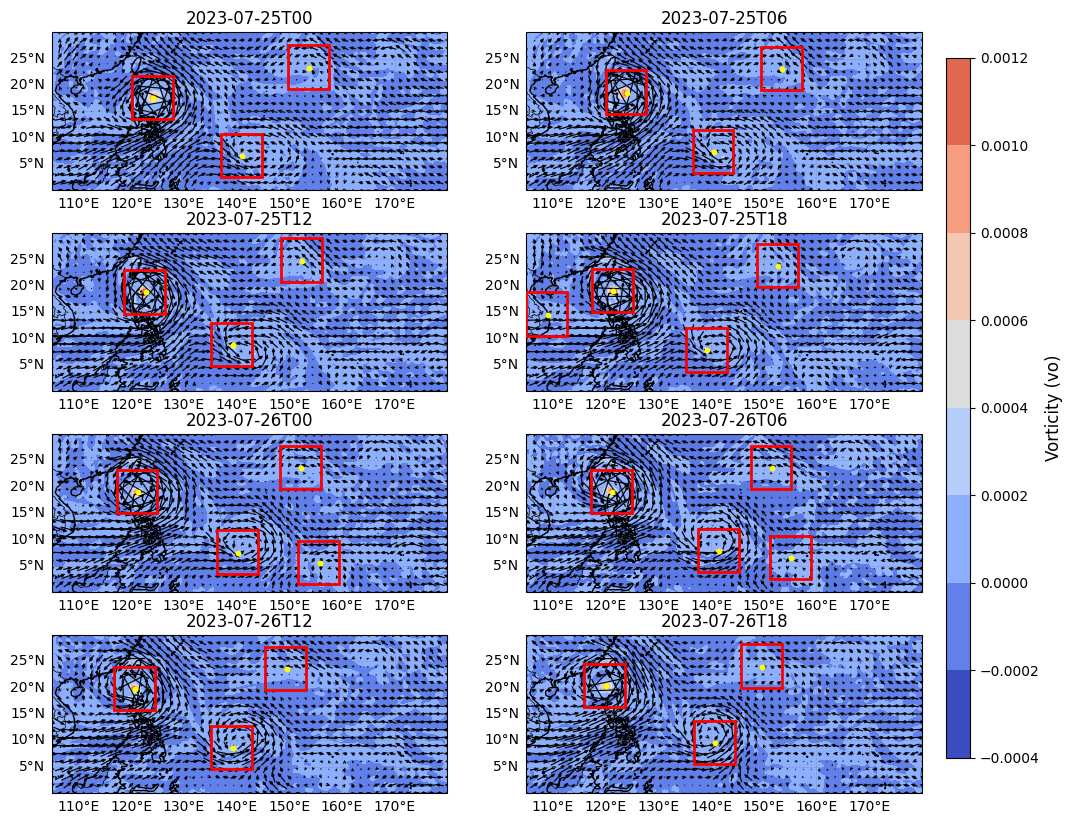

In [11]:
img_obj_smthtest = DrawImg(lons,lats,timeOfSpecific, (u_smth,v_smth, vo_smth) , save_img_pth= '此处未命名,因为现在没打算保存'    )                    
img_obj_smthtest.draw_img(get_dist_centerlist, test_list)  


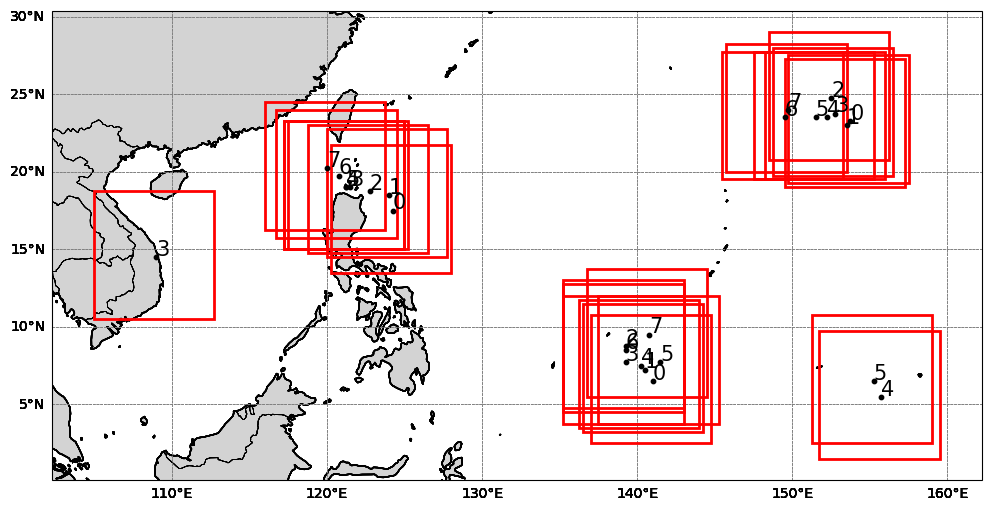

In [12]:
""" 将所有的时刻的点都画在同一张图上"""
wOfBox, hOfBox = 16, 16
vmin = np.min(vo_smth)  # 或者用 np.percentile(self.vo, 1)
vmax = np.max(vo_smth)  # 或者用 np.percentile(self.vo, 99)

fig, axes = plt.subplots( 1,1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()})
ax = axes
# 用于存储每个子图的 contourf 对象（用于 colorbar）
for i in range(len(timeOfSpecific)):     
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # 网格线
    gl = ax.gridlines(draw_labels=True,
                    x_inline=False, y_inline=False,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # 绘制风矢量（在上层）
    # # 降采样
    # skip = (slice(None, None, 6), slice(None, None, 6))
    # ax.quiver(lons[::6], lats[::6], u[i][skip], v[i][skip],
    #         scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
    #         color='k',
    #         pivot='middle',  # 箭头以(lon,lat)点为中心绘制
    #         width=0.003,  # 箭头宽度
    #         headwidth=3,   # 箭头头部宽度
    #         headlength= 3,  # 箭头头部长度
    #         zorder=1,
    #         transform=ccrs.PlateCarree())

    # # 画出流线图 
    # ax.streamplot(self.lons[::6], self.lats[::6], self.u[i][skip], self.v[i][skip],
    #         density= 4,   # 对应流线图  控制流线的数量和紧密程度
    #         # scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
    #         # color='k',
    #         # pivot='middle',  # 箭头以(lon,lat)点为中心绘制
    #         # width=0.003,  # 箭头宽度
    #         # headwidth=3,   # 箭头头部宽度
    #         # headlength= 3,  # 箭头头部长度
    #         color='k',
    #         zorder=1,
    #         transform=ccrs.PlateCarree())

# 
#     # 绘制 涡度的填色图（在底层），
#     cf = ax.contourf(self.lons, self.lats , self.vo[i], 
#                     cmap=colormaps['coolwarm'],
#                     vmin=vmin, vmax=vmax,  # 关键：统一颜色范围
#                     transform=ccrs.PlateCarree(),
#                     zorder=0)
#     contourf_plots.append(cf)
#     ax.set_title(f'{self.specific_times[i]}', fontsize=12)

    # # 画框
    colorlist = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray', 'pink']
    if test_list is not None:
        # 下方为测试散点
        for i_point_test in test_list[i]:   
            x_test , y_test =  i_point_test
            test_lon_start = lons[x_test - wOfBox]
            test_lat_start = lats[y_test + hOfBox]
            lon_width = lons[x_test + wOfBox - 1] - test_lon_start 
            lat_height = lats[y_test - hOfBox - 1] - test_lat_start
            # ax.scatter(test_lon_start, test_lat_start,  左下角  

            ax.scatter(lons[x_test], lats[y_test],  
                           # c = colorlist[i],
                           c = 'k',
                           s= 10,  # s 是面积，相当于 markersize^2
                           transform=ccrs.PlateCarree(),
                           zorder=6)
            rect = Rectangle((test_lon_start, test_lat_start ),
                                 lon_width, lat_height,
                                 linewidth=2, 
                                 edgecolor='red', facecolor='none',
                                 linestyle='-', 
                                 zorder=5,
                                 transform=ccrs.PlateCarree())
            ax.add_patch(rect)

            # 标记点对应的时刻的索引
            ax.text(
                lons[x_test],  # x 坐标（经度）
                lats[y_test] + 0.1,  # y 坐标（纬度）稍微上移 0.1 度
                str(i),  # 标注内容（这里用 `i` 作为示例）
                # color=colorlist[i],
                color = 'k',
                fontsize= 15,
                transform=ccrs.PlateCarree(),
                zorder=7  # 确保文本在散点和矩形之上
        )


(144, 94, 0)
(77, 50, 1)
(195, 27, 2)
(142, 91, 0)
(76, 46, 1)
(194, 28, 2)
(137, 85, 0)
(71, 45, 1)
(190, 21, 2)
(137, 89, 0)
(66, 44, 1)
(191, 25, 2)
(141, 90, 0)
(65, 44, 1)
(189, 26, 2)
(146, 89, 0)
(65, 44, 1)
(186, 26, 2)
(137, 86, 0)
(63, 41, 1)
(178, 26, 2)
(143, 82, 0)
(179, 24, 2)
(60, 39, 1)


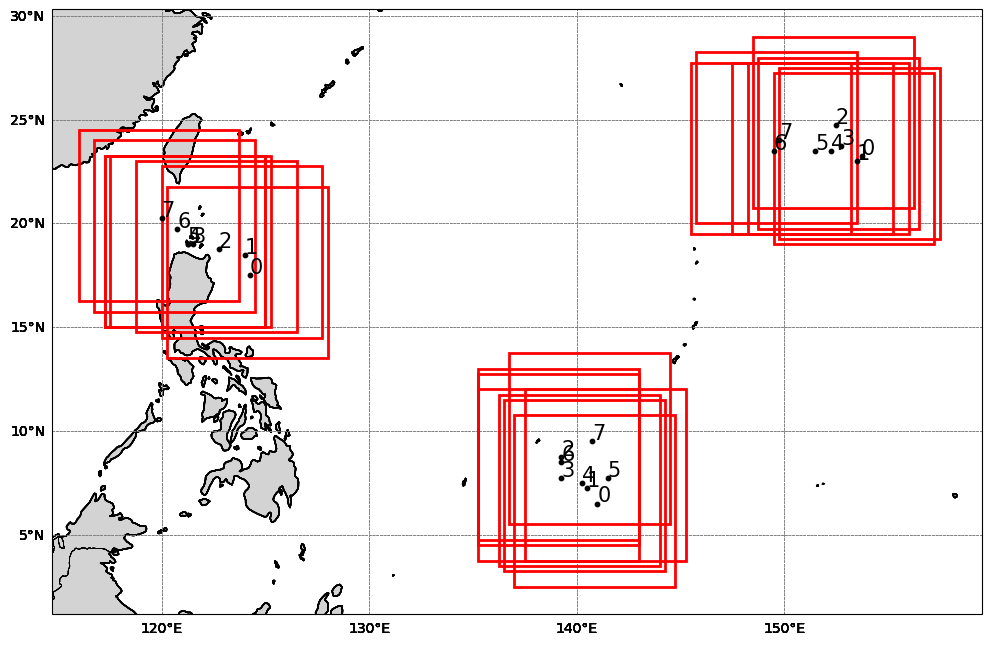

In [13]:
"""  将所有的时刻的点都画在同一张图上 """
wOfBox, hOfBox = 16, 16
vmin = np.min(vo_smth)  # 或者用 np.percentile(self.vo, 1)
vmax = np.max(vo_smth)  # 或者用 np.percentile(self.vo, 99)

fig, axes = plt.subplots( 1,1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()})
ax = axes
# 用于存储每个子图的 contourf 对象（用于 colorbar）
for i in range(len(timeOfSpecific)):     
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # 网格线
    gl = ax.gridlines(draw_labels=True,
                    x_inline=False, y_inline=False,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # # 画框
    colorlist = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray', 'pink']
    if test_list is not None:
        # 下方为测试散点    
        for i_point_test in tracked_list[i]: 
            print(i_point_test)
            x_test , y_test, id =  i_point_test
            
            test_lon_start = lons[x_test - wOfBox]
            test_lat_start = lats[y_test + hOfBox]
            lon_width = lons[x_test + wOfBox - 1] - test_lon_start 
            lat_height = lats[y_test - hOfBox - 1] - test_lat_start
            # ax.scatter(test_lon_start, test_lat_start,  左下角  

            ax.scatter(lons[x_test], lats[y_test],  
                           # c = colorlist[i],
                           c = 'k',
                           s= 10,  # s 是面积，相当于 markersize^2
                           transform=ccrs.PlateCarree(),
                           zorder=6)
            rect = Rectangle((test_lon_start, test_lat_start ),
                                 lon_width, lat_height,
                                 linewidth=2, 
                                 edgecolor='red', facecolor='none',
                                 linestyle='-', 
                                 zorder=5,
                                 transform=ccrs.PlateCarree())
            ax.add_patch(rect)

            # 标记点对应的时刻的索引
            ax.text(
                lons[x_test],  # x 坐标（经度）
                lats[y_test] + 0.1,  # y 坐标（纬度）稍微上移 0.1 度
                str(i),  # 标注内容（这里用 `i` 作为示例）
                # color=colorlist[i],
                color = 'k',
                fontsize= 15,
                transform=ccrs.PlateCarree(),
                zorder=7  # 确保文本在散点和矩形之上
        )



# 判断发展扰动还是不发展扰动

In [302]:
# 读取ibtrace 数据
ibtrace_pth = r"C:\Users\2892706668\Desktop\IBTrACS.WP.v04r01_20250727.nc"
ibtrace_data = xr.open_dataset(ibtrace_pth)
# print(ibtrace_data.lat.values)
# lon, lat 的范围设置一下
mask = ( 
    (ibtrace_data.lon < 180) & (105 < ibtrace_data.lon) & \
    (ibtrace_data.lat > 0) & (ibtrace_data.lat < 30)
)
ibtrace_data = ibtrace_data.where(mask, drop = True)


# # 筛选杜苏芮对应的数据 2023 
# # mask1 = ibtrace_data.name.isin([b'DOKSURI']) 
# mask2 = ibtrace_data.time.dt.year == 2023
# data_hasmask = ibtrace_data.where( mask2, drop=True)


D:\myAnaconda_base\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
D:\myAnaconda_base\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
D:\myAnaconda_base\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
D:\myAnaconda_base\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
D:\myAnaconda_base\Lib\site-packages\xarray\coding\times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
D:\myAnaconda_base\Lib\site-pa

In [303]:
print(ibtrace_data.time.values)

[['1884-06-24T16:00:00.000026880' '1884-06-24T18:00:00.000040192'
  '1884-06-24T21:00:00.000040192' ...                           'NaT'
                            'NaT'                           'NaT']
 ['1884-07-03T16:00:00.000026880' '1884-07-03T18:00:00.000040192'
  '1884-07-03T21:00:00.000040192' ...                           'NaT'
                            'NaT'                           'NaT']
 ['1884-07-08T16:00:00.000026880' '1884-07-08T18:00:00.000040192'
  '1884-07-08T21:00:00.000040192' ...                           'NaT'
                            'NaT'                           'NaT']
 ...
 ['2025-07-22T06:00:00.000039936' '2025-07-22T09:00:00.000039936'
  '2025-07-22T12:00:00.000039936' ...                           'NaT'
                            'NaT'                           'NaT']
 ['2025-07-23T00:00:00.000039936' '2025-07-23T03:00:00.000039936'
  '2025-07-23T06:00:00.000039936' ...                           'NaT'
                            'NaT'              

In [284]:
data_hasmask = ibtrace_data

In [304]:
mask2 = ibtrace_data.time.dt.year == 2023 
time_range = np.array([ '2023-07-25T00:00:00.000039936' ,'2023-07-25T03:00:00.000039936',
  '2023-07-25T06:00:00.000039936', '2023-07-25T09:00:00.000039936',
  '2023-07-25T12:00:00.000039936' ,'2023-07-25T15:00:00.000039936',
  '2023-07-25T18:00:00.000039936' ,'2023-07-25T21:00:00.000039936',
  '2023-07-26T00:00:00.000039936', '2023-07-26T03:00:00.000039936',
  '2023-07-26T06:00:00.000039936' ,'2023-07-26T09:00:00.000039936',
  '2023-07-26T12:00:00.000039936' ,'2023-07-26T15:00:00.000039936',
  '2023-07-26T18:00:00.000039936'], dtype='datetime64[ns]')[::2]
a = ibtrace_data.where(
    (ibtrace_data.name.isin(b'KHANUN'))&mask2 ,
    drop= True
)

a = a.where(a.time.isin(time_range), drop=True) 


D:\myAnaconda_base\Lib\site-packages\xarray\core\accessor_dt.py:122: RuntimeWarning: invalid value encountered in cast
  return access_method(values, name).astype(dtype, copy=False)


In [306]:
print(a.time.values)
print(a.lon.values, a.lat.values)

[['2023-07-26T06:00:00.000039936' '2023-07-26T12:00:00.000039936'
  '2023-07-26T18:00:00.000039936']]
[[141.3 141.1 140.6]] [[ 8.9  9.7 10.6]]


In [307]:
# one_kt = 1852/3600  # 1 kt = 1852/3600 m/s   
# time = data_hasmask.time.values[0]        
# get_dbOfTC_mask = (data_hasmask.usa_status.values == b'DB')  # 直接利用数据中的扰动, 里面的变量的值可能会有nan 
# windOfboundary_mask = (data_hasmask.usa_wind.values*one_kt > 12 )  
# timeBoundary = np.sort(data_hasmask.time.values[get_dbOfTC_mask & windOfboundary_mask])[0] # 获取第一个满足条件的时间 
# time_index = np.where(data_hasmask.time.values.flatten() == timeBoundary)[0].item()
# time_range = time[time_index-4:time_index] 
time_range = np.array([ '2023-07-25T00:00:00.000039936' ,'2023-07-25T03:00:00.000039936',
  '2023-07-25T06:00:00.000039936', 
  '2023-07-25T12:00:00.000039936' ,
  '2023-07-25T18:00:00.000039936' ,
  '2023-07-26T00:00:00.000039936', 
  '2023-07-26T06:00:00.000039936' ,
  '2023-07-26T12:00:00.000039936' ,
  '2023-07-26T18:00:00.000039936', 
'2023-07-27T00:00:00.000039936', 
                        ], dtype='datetime64[ns]')
data_hasmask = data_hasmask.where(data_hasmask.time.isin(time_range), drop=True)   

In [312]:
print(data_hasmask.sel(storm = 0 ).time.values)
print(data_hasmask.sel(storm = 1 ).time.values)


['2023-07-20T06:00:00.000039936' '2023-07-20T18:00:00.000039936'
 '2023-07-25T00:00:00.000039936' '2023-07-25T06:00:00.000039936'
 '2023-07-25T18:00:00.000039936' '2023-07-26T06:00:00.000039936'
 '2023-07-26T18:00:00.000039936']
['2023-07-26T06:00:00.000039936' '2023-07-26T18:00:00.000039936'
 '2023-07-31T00:00:00.000039936' '2023-07-31T06:00:00.000039936'
 '2023-07-31T18:00:00.000039936' '2023-08-01T06:00:00.000039936'
 '2023-08-01T18:00:00.000039936']


In [313]:
print(data_hasmask.lon.values)

[[133.7 133.2 124.6 123.7 121.6 121.  120. ]
 [141.3 140.6 132.  131.5 130.3 128.7 127.4]]


In [314]:
print(data_hasmask.sid.values)

[[nan nan b'2023201N13134' b'2023201N13134' b'2023201N13134'
  b'2023201N13134' b'2023201N13134']
 [b'2023207N09141' b'2023207N09141' nan nan nan nan nan]]


In [317]:
print(data_hasmask.storm.values)

[0 1]


In [322]:
b = data_hasmask.where(data_hasmask.time == time_range)
print(b)


ValueError: operands could not be broadcast together with shapes (2,7) (10,) 

In [286]:
# 获取台风中心
# y_tc_center = data_hasmask.usa_lat.values[0]
# x_tc_center= data_hasmask.usa_lon.values[0]
all_tc_center_list = []
for i_t in range(len(time_range)):
    i_t_TcCenter_list =  []
    # 拿出每一个台风
    for i_storm in range(data_hasmask.storm.values):
        i_tOfTc_y = data_hasmask.where(data_hasmask.time[i_storm] == time_range[i_t]).lat.values[0]
        i_tOfTc_x = data_hasmask.where(data_hasmask.time[i_storm] == time_range[i_t]).lon.values[0]
        print(i_tOfTc_x)
        for i in range(len(i_tOfTc_x)):
            i_pt_x = i_tOfTc_x[i]
            i_pt_y = i_tOfTc_y[i]
            i_t_TcCenter_list.append((i_pt_x, i_pt_y))
        all_tc_center_list.append(i_t_TcCenter_list)



[133.7 133.5 133.2 124.6 123.7 122.7 121.6 121.4 121.  120.6 120. ]
[133.7 133.5 133.2 124.6 123.7 122.7 121.6 121.4 121.  120.6 120. ]
[133.7 133.5 133.2 124.6 123.7 122.7 121.6 121.4 121.  120.6 120. ]
[133.7 133.5 133.2 124.6 123.7 122.7 121.6 121.4 121.  120.6 120. ]
[133.7 133.5 133.2 124.6 123.7 122.7 121.6 121.4 121.  120.6 120. ]
[133.7 133.5 133.2 124.6 123.7 122.7 121.6 121.4 121.  120.6 120. ]
[133.7 133.5 133.2 124.6 123.7 122.7 121.6 121.4 121.  120.6 120. ]
[133.7 133.5 133.2 124.6 123.7 122.7 121.6 121.4 121.  120.6 120. ]


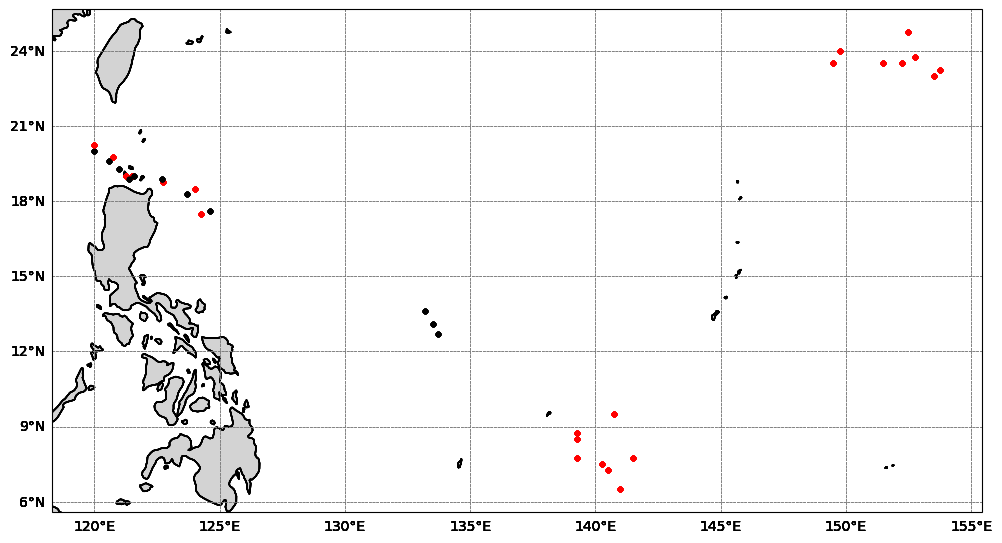

In [243]:
"""  将所有的时刻的点都画在同一张图上 """
wOfBox, hOfBox = 16, 16
vmin = np.min(vo_smth)  # 或者用 np.percentile(self.vo, 1)
vmax = np.max(vo_smth)  # 或者用 np.percentile(self.vo, 99)

fig, axes = plt.subplots( 1,1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()})
ax = axes
# 用于存储每个子图的 contourf 对象（用于 colorbar）
for i in range(len(time_range)):     
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # 网格线
    gl = ax.gridlines(draw_labels=True,
                    x_inline=False, y_inline=False,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # # 画框
    colorlist = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray', 'pink']
    if all_tc_center_list is not None:
        # 下方为测试散点    
        for i_point_test in all_tc_center_list[i]: 
            # print(i_point_test)
            x_test , y_test =  i_point_test
            ax.scatter(  x_test, y_test  ,       #lons[x_test], lats[y_test],  
                           # c = colorlist[i],
                           c = 'k',
                           s= 10,  # s 是面积，相当于 markersize^2
                           transform=ccrs.PlateCarree(),
                           zorder=6)
            
            for i_point_test in tracked_list[i]: 
                # print(i_point_test)
                x_test , y_test , id =  i_point_test
                
                test_lon_start = lons[x_test - wOfBox]
                test_lat_start = lats[y_test + hOfBox]
                lon_width = lons[x_test + wOfBox - 1] - test_lon_start 
                lat_height = lats[y_test - hOfBox - 1] - test_lat_start
                # ax.scatter(test_lon_start, test_lat_start,  左下角  
    
                ax.scatter(  lons[x_test], lats[y_test],  
                               # c = colorlist[i],
                               c = 'r',
                               s= 10,  # s 是面积，相当于 markersize^2
                               transform=ccrs.PlateCarree(),
                               zorder=6) 
            
            
            # rect = Rectangle((test_lon_start, test_lat_start ),
            #                      lon_width, lat_height,
            #                      linewidth=2, 
            #                      edgecolor='red', facecolor='none',
            #                      linestyle='-', 
            #                      zorder=5,
            #                      transform=ccrs.PlateCarree())
            # ax.add_patch(rect)

            # # 标记点对应的时刻的索引
            # ax.text(
            #     lons[x_test],  # x 坐标（经度）
            #     lats[y_test] + 0.1,  # y 坐标（纬度）稍微上移 0.1 度
            #     str(i),  # 标注内容（这里用 `i` 作为示例）
            #     # color=colorlist[i],
            #     color = 'k',
            #     fontsize= 15,
            #     transform=ccrs.PlateCarree(),
            #     zorder=7  # 确保文本在散点和矩形之上
           # )




In [13]:
def judegeDevOrNonDev(tracked_list):
    pass 